<a href="https://colab.research.google.com/github/knoppin1/DATA-606/blob/main/county_covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import wget
import missingno as msno
import pickle

## 1 - Read COVID-19 Daily Report

In [ ]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/06-11-2021.csv'
covid_file = wget.download(url)

Read the COVID data into a dataframe.

In [ ]:
covid_df = pd.read_csv("06-11-2021.csv")
covid_df.head().T

,0,1,2,3,4
FIPS,NaN,NaN,NaN,NaN,NaN
Admin2,NaN,NaN,NaN,NaN,NaN
Province_State,NaN,NaN,NaN,NaN,NaN
Country_Region,Afghanistan,Albania,Algeria,Andorra,Angola
Last_Update,2021-06-12 04:22:22,2021-06-12 04:22:22,2021-06-12 04:22:22,2021-06-12 04:22:22,2021-06-12 04:22:22
Lat,33.9391,41.1533,28.0339,42.5063,-11.2027
Long_,67.71,20.1683,1.6596,1.5218,17.8739
Confirmed,87716,132437,132727,13813,36455
Deaths,3412,2453,3560,127,819
Recovered,60598,129807,92384,13591,30101


In [ ]:
covid_df.shape

(3984, 14)

### 1.1 - Cleanup Columns

In [ ]:
# Display columns
covid_df.columns

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incident_Rate', 'Case_Fatality_Ratio'],
      dtype='object')

In [ ]:
# Rename the Admin2 and Combined_Key columns to County and Place.
covid_df.rename(columns = {'Admin2':'County', 'Combined_Key':'Place'}, inplace = True)
covid_df.columns

Index(['FIPS', 'County', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Place',
       'Incident_Rate', 'Case_Fatality_Ratio'],
      dtype='object')

In [ ]:
# Remove columns that are irrelevant to the study.
irrelevant_columns = ['Last_Update', 'Lat', 'Long_', 'Recovered', 'Active','Incident_Rate','Case_Fatality_Ratio']
covid_df = covid_df.drop(irrelevant_columns, axis=1)
covid_df.head(3)

,FIPS,County,Province_State,Country_Region,Confirmed,Deaths,Place
0,NaN,NaN,NaN,Afghanistan,87716,3412,Afghanistan
1,NaN,NaN,NaN,Albania,132437,2453,Albania
2,NaN,NaN,NaN,Algeria,132727,3560,Algeria


In [ ]:
# Reorder columns
column_order = ['FIPS','County','Province_State','Country_Region','Place','Confirmed','Deaths'] 
covid_df = covid_df[column_order] 
covid_df.head(3) 

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths
0,NaN,NaN,NaN,Afghanistan,Afghanistan,87716,3412
1,NaN,NaN,NaN,Albania,Albania,132437,2453
2,NaN,NaN,NaN,Algeria,Algeria,132727,3560


In [ ]:
# Show revised Covid dataframe dimensions.  
covid_df.shape

(3984, 7)

### 1.2 - Remove Irrelevant Data

In [ ]:
# Drop duplicate rows.
[row for row in covid_df.duplicated(keep='last') if row == True]

[]

In [ ]:
# No duplicates were found, so dropping duplicates will not have any effect.
covid_df = covid_df.drop_duplicates(keep='last')
covid_df.shape

(3984, 7)

Determine how much of the dataframe is useful for the study.

In [ ]:
covid_df["Country_Region"].value_counts().head(10)

US          3277
Russia        83
Japan         49
India         37
Colombia      34
China         34
Mexico        33
Ukraine       27
Brazil        27
Peru          26
Name: Country_Region, dtype: int64

Note: Non-US data is irrelvant since only US counties are being studied.

Only keep the records representing US data.

In [ ]:
# Drop all non-US data rows.
covid_us_df = covid_df[covid_df.Country_Region == "US"]
covid_us_df.shape

(3277, 7)

In [ ]:
# Check data types and counts.
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3984 entries, 0 to 3983
Data columns (total 7 columns):
FIPS              3266 non-null float64
County            3271 non-null object
Province_State    3812 non-null object
Country_Region    3984 non-null object
Place             3984 non-null object
Confirmed         3984 non-null int64
Deaths            3984 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 249.0+ KB


The Non-Null counts are not the same, so cleanup missing data before moving forward.

### 1.3 - Cleanup Missing Data

Visualize the dataframe to identify missing data.

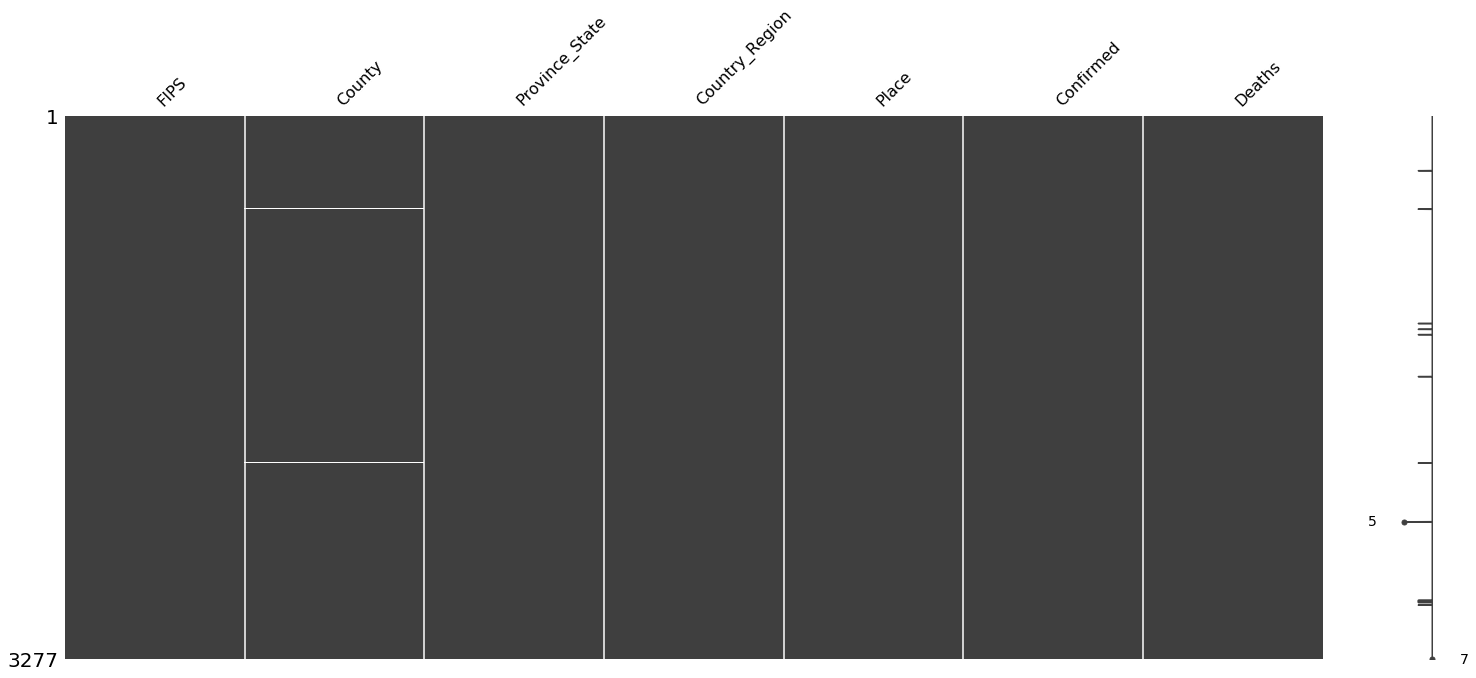

In [ ]:
# Reference: https://analyticsindiamag.com/tutorial-on-missingno-python-tool-to-visualize-missing-values/
import missingno as msno
msno.matrix(covid_us_df)

Investigate records without a FIPS code

In [ ]:
covid_nofips_us_df = covid_us_df[covid_us_df.FIPS.isna()]
covid_nofips_us_df.shape

(11, 7)

In [ ]:
covid_nofips_us_df

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths
1905,NaN,Dukes and Nantucket,Massachusetts,US,"Dukes and Nantucket, Massachusetts, US",2932,5
1940,NaN,Federal Correctional Institution (FCI),Michigan,US,"Federal Correctional Institution (FCI), Michig...",316,5
1972,NaN,Michigan Department of Corrections (MDOC),Michigan,US,"Michigan Department of Corrections (MDOC), Mic...",26914,152
2225,NaN,Kansas City,Missouri,US,"Kansas City, Missouri, US",44863,591
3100,NaN,NaN,Recovered,US,"Recovered, US",0,0
3573,NaN,Bear River,Utah,US,"Bear River, Utah, US",22134,106
3574,NaN,Central Utah,Utah,US,"Central Utah, Utah, US",9091,68
3578,NaN,Southeast Utah,Utah,US,"Southeast Utah, Utah, US",3668,28
3579,NaN,Southwest Utah,Utah,US,"Southwest Utah, Utah, US",29420,275
3582,NaN,TriCounty,Utah,US,"TriCounty, Utah, US",4308,38


Records lacking a FIPS code cannot be used in the study because the field will be joined with land area data needed to determine population density for each county.

Remove the records without a FIPS code.

In [ ]:
covid_us_df = covid_us_df[covid_us_df.FIPS.notna()]
covid_us_df.shape

(3266, 7)

Investigate records without a County.

In [ ]:
covid_no_county_us_df = covid_us_df[covid_us_df.County.isna()]
covid_no_county_us_df.shape

(5, 7)

In [ ]:
covid_no_county_us_df

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths
984,88888.0,NaN,Diamond Princess,US,"Diamond Princess, US",49,0
1215,99999.0,NaN,Grand Princess,US,"Grand Princess, US",103,3
1216,66.0,NaN,Guam,US,"Guam, US",8236,139
2746,69.0,NaN,Northern Mariana Islands,US,"Northern Mariana Islands, US",183,2
3602,78.0,NaN,Virgin Islands,US,"Virgin Islands, US",3690,28


These records represent provinces or special COVID groupings irrelevant to the study and can be removed.

In [ ]:
covid_us_df = covid_us_df[covid_us_df.County.notna()]
covid_us_df.shape

(3261, 7)

In [ ]:
covid_us_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3261 entries, 653 to 3929
Data columns (total 7 columns):
FIPS              3261 non-null float64
County            3261 non-null object
Province_State    3261 non-null object
Country_Region    3261 non-null object
Place             3261 non-null object
Confirmed         3261 non-null int64
Deaths            3261 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 203.8+ KB


All NaNs addressed. Check column statistics to identify any other missing data

In [ ]:
covid_us_df.describe(include='all')

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths
count,3261.000000,3261,3261,3261,3261,3.261000e+03,3261.000000
unique,NaN,1916,52,1,3261,NaN,NaN
top,NaN,Unassigned,Texas,US,"Irion, Texas, US",NaN,NaN
freq,NaN,51,255,3261,1,NaN,NaN
mean,32392.964428,NaN,NaN,NaN,NaN,1.019987e+04,183.294695
std,17954.793468,NaN,NaN,NaN,NaN,3.665290e+04,712.187197
min,1001.000000,NaN,NaN,NaN,NaN,0.000000e+00,0.000000
25%,19053.000000,NaN,NaN,NaN,NaN,1.024000e+03,17.000000
50%,30069.000000,NaN,NaN,NaN,NaN,2.485000e+03,47.000000
75%,47039.000000,NaN,NaN,NaN,NaN,6.414000e+03,114.000000


Note "Unassigned" is the most frequent value in the "Admin2" column, which represents a county.

This field should not be unassigned and needs to be investigated.

In [ ]:
unassigned_df = covid_us_df[covid_us_df.County == "Unassigned"] 
unassigned_df.shape

(51, 7)

In [ ]:
unassigned_df.sample(10)

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths
717,90001.0,Unassigned,Alabama,US,"Unassigned, Alabama, US",0,0
1898,90024.0,Unassigned,Maryland,US,"Unassigned, Maryland, US",0,32
2909,90040.0,Unassigned,Oklahoma,US,"Unassigned, Oklahoma, US",506,0
3216,90046.0,Unassigned,South Dakota,US,"Unassigned, South Dakota, US",0,0
3825,90054.0,Unassigned,West Virginia,US,"Unassigned, West Virginia, US",0,0
748,90002.0,Unassigned,Alaska,US,"Unassigned, Alaska, US",292,0
2163,90028.0,Unassigned,Mississippi,US,"Unassigned, Mississippi, US",0,0
1552,90019.0,Unassigned,Iowa,US,"Unassigned, Iowa, US",952,0
2741,90038.0,Unassigned,North Dakota,US,"Unassigned, North Dakota, US",0,31
2457,90032.0,Unassigned,Nevada,US,"Unassigned, Nevada, US",0,0


Records with county field value of "Unassigned" represent states.

The study is looking at county-level population denisty, so state records are irrelevant and can be removed.

Remove the records with the county "Unassigned".

In [ ]:
covid_counties_df = covid_us_df[covid_us_df.County != "Unassigned"]
covid_counties_df.shape

(3210, 7)

### 1.4 - Verify Data Types

In [ ]:
covid_counties_df.dtypes

FIPS              float64
County             object
Province_State     object
Country_Region     object
Place              object
Confirmed           int64
Deaths              int64
dtype: object

FIPS code was read in as float because there were NaNs and that is a float type.

FIPS should be integer, so recast the column from float64 to int

Reference: https://stackoverflow.com/questions/49728421/pandas-dataframe-settingwithcopywarning-a-value-is-trying-to-be-set-on-a-copy

In [ ]:
covid_counties_df = covid_counties_df.assign(FIPS=lambda x: x['FIPS'].astype(int))

In [ ]:
covid_counties_df.sample(5)

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths
3371,48107,Crosby,Texas,US,"Crosby, Texas, US",699,29
2995,42087,Mifflin,Pennsylvania,US,"Mifflin, Pennsylvania, US",5416,179
2703,38023,Divide,North Dakota,US,"Divide, North Dakota, US",187,2
2418,31141,Platte,Nebraska,US,"Platte, Nebraska, US",4152,50
2254,29159,Pettis,Missouri,US,"Pettis, Missouri, US",5188,77


In [ ]:
# Rename the Province_State, and Country_Region to State and Country.
covid_counties_df.rename(columns = {'Province_State':'State', 'Country_Region':'Country'}, inplace = True)
covid_counties_df.columns

Index(['FIPS', 'County', 'State', 'Country', 'Place', 'Confirmed', 'Deaths'], dtype='object')

In [ ]:
# Check number of States/Provinces
covid_counties_df.State.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [ ]:
num_provinces_states = len(covid_counties_df.State.unique())
num_provinces_states

52

Note that Puerto Rico and Washington, DC are included in the data.

### 1.5 - Plot Data

Display an interactive scatter plot of the COVID-19 cases versus deaths by County.

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe_connected'

In [ ]:
fig = px.scatter(covid_counties_df,x='Confirmed', y='Deaths',hover_data=['State','County'])
fig.update_layout(title="County Confirmed COVID-19 Cases and Death Counts", title_x=0.5)
fig.show()

### 1.5 - Save COVID-19 Data to Pickle File

In [ ]:
covid_counties_df.to_pickle("./covid.pkl")